In [3]:
import laserhockey.hockey_env as h_env
import numpy as np
import torch
import time
from sac import SAC_Agent
from dsac import DSAC_Agent
import matplotlib.pyplot as plt

Using device: cpu
Using device: cpu


In [20]:
torch.manual_seed(42)
np.random.seed(42)

env = h_env.HockeyEnv()
agent = SAC_Agent(env.observation_space,env.action_space)
agent.load_network_states(torch.load("./results/SAC/SAC_easy-e25000-t32-s42-player.pth", map_location=torch.device('cpu')))
agent.eval()
#agent.load_network_states(torch.load("SAC_run_easy-e1500-t32-s42-player.pth"))
opponent = h_env.BasicOpponent(weak=False)

loss = 0
win = 0
tie = 0

for run in range(0,5):
    ob, info = env.reset()
    ob_opponent = env.obs_agent_two()
    for t in range(1,1000):
        action = agent.act(ob)
        opponent_action = opponent.act(ob_opponent)
        #opponent_action = np.zeros_like(opponent_action)
        ob_new,reward,done,trunc,info = env.step(np.hstack([action,opponent_action]))
        info_opponent = env.get_info_agent_two()
        #if info["reward_touch_puck"]!=0:
        #    print(info)
        #    print("touched")
        time.sleep(0.05)
        env.render()
        #print(info["reward_closeness_to_puck"])
        if done:
            if env.winner ==1:
                win +=1
                #if reward > 0:
                #    print(reward)
            elif env.winner == -1: 
                loss +=1
            else:
                tie +=1
            break
        #if reward > 0:
        #    print(reward)

        ob = ob_new
        ob_opponent = env.obs_agent_two()
print(info)
env.close()

print(f"win(left_side): {win},loss: {loss}, tie: {tie}")

halfed the action space to 4
Agent now in evaluation Mode
{'winner': 0, 'reward_closeness_to_puck': -0.14198949147620474, 'reward_touch_puck': 0.0, 'reward_puck_direction': -0.0010783462524414063}
win(left_side): 3,loss: 0, tie: 2


In [16]:
env.close()

In [ ]:
import matplotlib.pyplot as plt
import pickle

with open(f"SAC_Easy_easy-s42-e4500-stat.pkl", 'rb') as f:
    data = pickle.load(f)
    rewards = np.asarray(data["rewards"])
    q_losses =  np.asarray(data["q_losses"])
    pi_losses  = np.asarray(data["pi_losses"])
    temperature_losses = np.asarray(data["temperature_loss"])

In [29]:
DSAC_easy = b = np.load('DSAC_easy.npy', allow_pickle=True)
winrate = DSAC_easy[:,0]/(DSAC_easy[:,0]+DSAC_easy[:,1])

C:\Users\super\AppData\Local\Temp\ipykernel_10820\1398379337.py:2: RuntimeWarning: invalid value encountered in divide
  winrate = DSAC_easy[:,0]/(DSAC_easy[:,0]+DSAC_easy[:,1])


In [4]:
def calculate_winrate(stats):
    return stats[:,0]/(stats[:,0]+stats[:,1]+stats[:,2])

In [119]:
def get_winrates(files):
    timelines = np.zeros((1,41))
    for file in files:
        stats = np.load(file, allow_pickle=True)
        winrate = calculate_winrate(stats)
        timelines = np.vstack([timelines,winrate])
    return timelines[1:]


def plot_timelines(title,timelines,legends):
    plt.figure(figsize=(14, 4))
    for i in range(len(legends)):
        winrate = timeline[i]
        stop = 20000+500
        plt.plot(range(0,stop,500),winrate,'-o')
        plt.legend(legends)

        #TODO add axis titles
    plt.grid(axis='x',color='grey', linestyle='--', linewidth=0.5, alpha=0.3)
    plt.xlabel("training episode")
    plt.ylabel("winrate")
    ticks = range(0,20200,500)
    plt.xticks(ticks)
    for index, tick in enumerate(plt.gca().xaxis.get_major_ticks()):
        if index % 2 != 0:
            tick.label1.set_visible(False) 

    y_tick_positions = np.arange(0,1.25,0.25)
    y_tick_labels = [f'{tick:.2f}' for tick in y_tick_positions]
    plt.yticks(y_tick_positions, y_tick_labels)
    
    y_grid_positions = [0,0.25, 0.5,0.75, 1]
    for y_grid in y_grid_positions:
        plt.axhline(y=y_grid, color='grey', linestyle='-', linewidth=0.5, alpha=0.1)
    

    plt.suptitle(title)
    plt.xlim(-80, 20100)
    plt.ylim(-0.05, None)
    plt.tight_layout()
    plt.savefig('example.png')

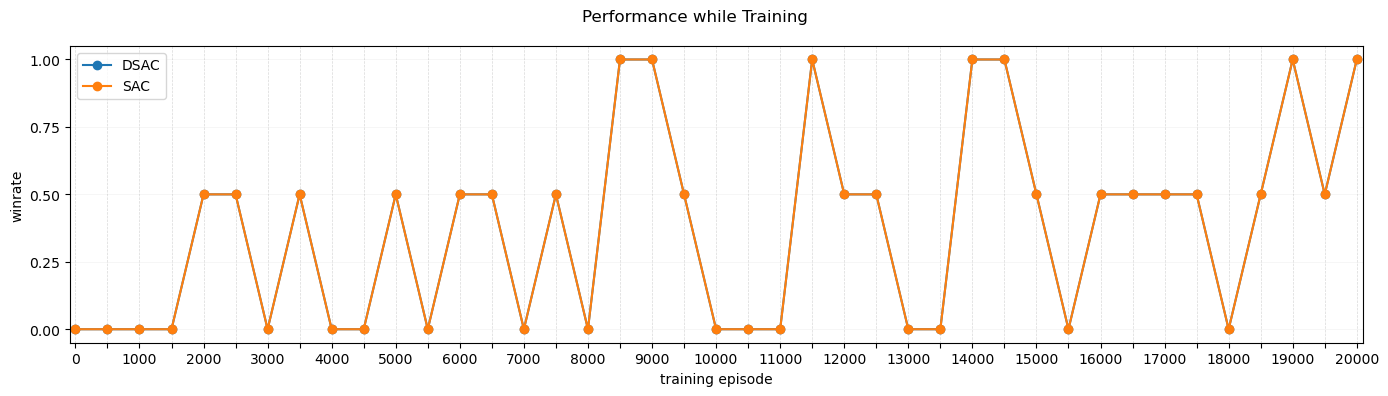

In [120]:
timeline = get_winrates(['DSAC_easy.npy','DSAC_easy.npy'])
plot_timelines("Performance while Training",timeline,['DSAC','SAC'])

In [1]:
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'